In [1]:
from perception import hashers
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.config import config
from src.phishIRISData import PhishIRISDataset, formatted_name

hasher = hashers.PHashF()
train_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="train", preprocess=False
)

In [2]:
kmeans = KMeans(n_clusters=15, init="k-means++", n_init="auto")
clusters = kmeans.fit(list(train_dataset.img_to_hash.values()))
data_transformed = kmeans.transform(list(train_dataset.img_to_hash.values()))

In [3]:
(
    clusters.labels_[2],
    train_dataset.hash_to_img[
        hasher.vector_to_string(list(train_dataset.img_to_hash.values())[2])
    ],
)

(13, 'apple-(6).png')

### Visualize the clusters

In [ ]:
# Visualize cluster distribution per company
"""
# TODO: wypisz dominujaca klase z kazdego klastra
# dict klasa -> nr klastra
# jakies metryczki z TP, TN, FP, FN i inne z scikit learna
# popraw kod xD

for company, imgs in img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(kmeans.predict([hasher.string_to_vector(hash_of_img)]))
    unique, counts = np.unique(predicted_class, return_counts=True)
    print(f'{company}: ', dict(zip(unique, counts)))
    print('='*10)
    
"""
for company, imgs in train_dataset.img_per_company.items():
    predicted_class = np.zeros(shape=(len(imgs)))
    for idx, hash_of_img in enumerate(imgs):
        predicted_class[idx] = int(
            kmeans.predict([hasher.string_to_vector(hash_of_img)])[0]
        )

    # Get the unique classes and their counts
    unique, counts = np.unique(predicted_class, return_counts=True)

    # Create a bar plot for this company
    plt.figure(figsize=(8, 5))
    plt.bar(unique, counts, color="orange")
    plt.xlabel("Cluster")
    plt.ylabel("Count of Images")
    plt.title(f"Class Distribution for {company}")
    plt.xticks(unique)
    plt.show()

    print(f"{company}: ", dict(zip(unique, counts)))
    print("=" * 10)

In [ ]:
# Visualize company distribution in each cluster
cluster_to_hash = defaultdict(list)
for idx, (img_name, img_hash) in enumerate(train_dataset.img_to_hash.items()):
    cluster_to_hash[kmeans.labels_[idx]].append(hasher.vector_to_string(img_hash))

for idx in range(clusters.n_clusters):
    labels = []
    for x in cluster_to_hash[idx]:
        labels.append(train_dataset.hash_to_company[x])
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    # Create a bar plot for the labels of this company
    plt.figure(figsize=(15, 5))
    plt.bar(unique_labels, label_counts, color="pink")
    plt.xlabel("Labels")
    plt.ylabel("Count of Images")
    plt.title(f"Label Distribution for cluster #{idx}")
    plt.xticks(unique_labels)
    plt.show()

    print(f"Cluster #{idx} Labels: ", dict(zip(unique_labels, label_counts)))
    print("=" * 10)

---

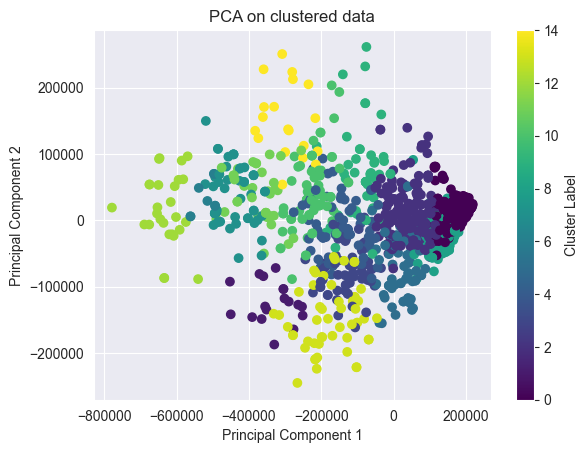

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2 dimensions using PCA
pca = PCA(n_components=2)
data_to_transform = []

for X, label in train_dataset:
    data_to_transform.append(train_dataset.img_to_hash[formatted_name(X)])

pca_data = pca.fit_transform(data_to_transform)

# Visualize the
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters.labels_, cmap="viridis")
plt.title("PCA on clustered data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")
plt.show()

### Get most common class in each cluster

In [5]:
cluster_to_hash = defaultdict(list)
cluster_to_company = defaultdict(list)
for idx, (img_name, img_hash) in enumerate(train_dataset.img_to_hash.items()):
    hsh = hasher.vector_to_string(img_hash)
    cluster_to_hash[kmeans.labels_[idx]].append(hsh)
    cluster_to_company[kmeans.labels_[idx]].append(train_dataset.hash_to_company[hsh])

for cluster_id in cluster_to_company.keys():
    companies, counts = np.unique(cluster_to_company[cluster_id], return_counts=True)
    # get max element from counts and its company
    cluster_to_company[cluster_id] = companies[np.argmax(counts)]

cluster_to_company

defaultdict(list,
            {8: 'facebook',
             13: 'other',
             0: 'paypal',
             5: 'other',
             7: 'other',
             1: 'other',
             9: 'other',
             2: 'other',
             3: 'other',
             10: 'other',
             4: 'other',
             11: 'other',
             14: 'other',
             12: 'other',
             6: 'paypal'})

In [6]:
val_dataset = PhishIRISDataset(
    data_dir=config.PHISHIRIS_DL_DATASET_DIR, split="val", preprocess=False
)

y_pred = [
    # get picture name and change space to '-'
    cluster_to_company[
        clusters.predict([val_dataset.img_to_hash[formatted_name(X)]])[0]
    ]
    for X, label in val_dataset
]
y_true = [label for _, label in val_dataset]

# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
print(f"acc:\t\t\t{accuracy * 100 :.5f}")
print(f"balanced_acc:\t{balanced_accuracy * 100:.5f}")

acc:			60.94867
balanced_acc:	12.75615


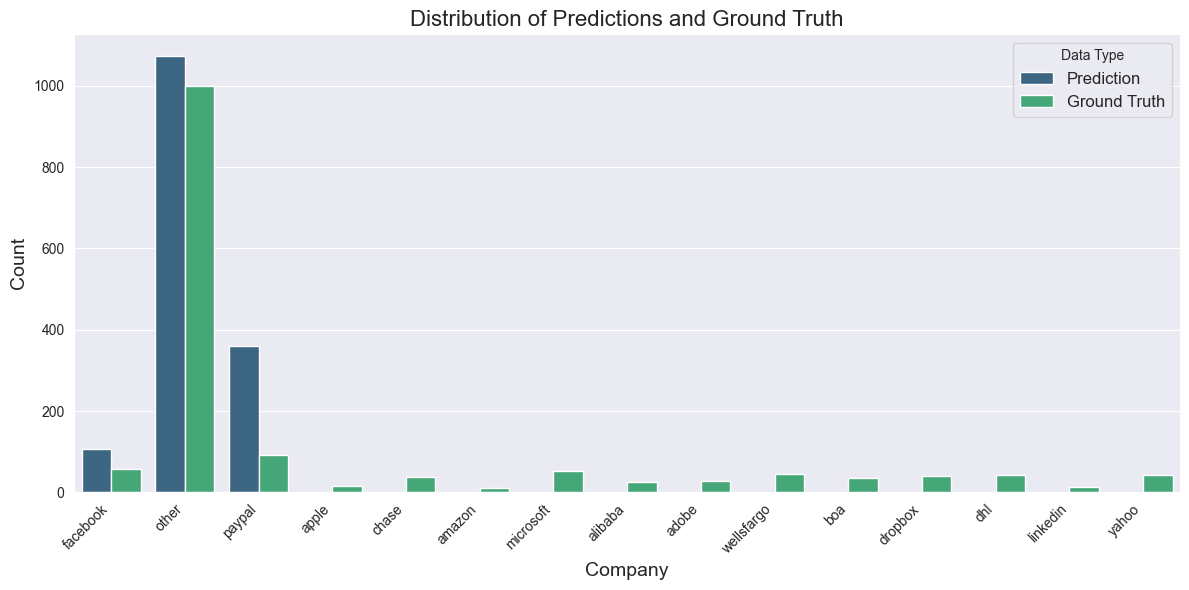

In [7]:
data = pd.DataFrame(
    {
        "Type": ["Prediction"] * len(y_pred) + ["Ground Truth"] * len(y_true),
        "Company": y_pred + y_true,
    }
)

plt.figure(figsize=(12, 6))
sns.countplot(data=data, x="Company", hue="Type", palette="viridis")

plt.title("Distribution of Predictions and Ground Truth", fontsize=16)
plt.xlabel("Company", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Data Type", fontsize=12)
plt.tight_layout()

plt.show()